In [1]:
%config IPCompleter.greedy=True
%config IPCompleter.use_jedi=False

In [2]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA, TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score, silhouette_samples, mean_squared_error
from sklearn.random_projection import GaussianRandomProjection
from sklearn import mixture
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

from numpy import linalg as LA

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import scipy
from scipy.linalg import pinv
import pandas as pd

import itertools
import scipy.stats

import time

import warnings
warnings.filterwarnings('ignore')

# import plotly.offline as py
# py.init_notebook_mode(connected=True)

# import plotly.graph_objs as go

from sklearn.preprocessing import StandardScaler

# Data

In [3]:
df = pd.read_csv('data/minist_train.csv')

df_sample = df.sample(10000)

y = df_sample[df_sample.columns[0]]
X = df_sample[df_sample.columns[1:]]

# split the training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dimensionality Reduction

## PCA

In [4]:
X_PCA = PCA(n_components = 6).fit_transform(X)

# PCA with Clustering

In [5]:
k = 7
k_means_clustering = KMeans(n_clusters=k, random_state=42)
k_means_clustering.fit_transform(X_PCA)

array([[1509.91012812, 1521.8426867 , 1551.25503253, ..., 1684.74348921,
        2155.62033709,  501.99052533],
       [1611.10369777, 1450.54628097, 1526.00029497, ..., 1367.49316796,
        1920.48483691, 1208.70393197],
       [1372.31797689,  553.35821524, 1175.33476471, ...,  754.30001183,
        1992.14608222, 1344.37747633],
       ...,
       [1996.51008071, 1312.59332127, 1802.95631781, ..., 1291.10633581,
        1495.44705927, 2057.24192942],
       [ 870.49562329, 1835.56341457, 1345.06822032, ..., 1551.01488855,
        1235.95292449, 1908.40860494],
       [1663.30060537,  487.78667851, 1399.55715915, ..., 1058.1511013 ,
        1824.41980476, 1206.29337361]])

In [6]:
X_KMeans = np.append(X_PCA, k_means_clustering.fit_transform(X_PCA), 1)
X_KMeans_train, X_KMeans_test, y_KMeans_train, y_KMeans_test = train_test_split(X_KMeans, y, test_size=0.3, random_state=42)

In [7]:
classifier_neural_network = MLPClassifier(random_state=42, max_iter=2000)
param_grid = {'alpha': np.logspace(-3,3,7), 'hidden_layer_sizes': np.arange(2,25,2)}
classifier_neural_network_best = GridSearchCV(classifier_neural_network, param_grid=param_grid, cv=4)

start_time = time.time()
classifier_neural_network_best.fit(X_KMeans_train, y_KMeans_train)
end_time = time.time()
time_train = end_time-start_time
print("Best params for neural network:",classifier_neural_network_best.best_params_)
print("Time to train:",time_train)

start_time = time.time()
classifier_accuracy = accuracy_score(y_KMeans_test, classifier_neural_network_best.predict(X_KMeans_test))
end_time = time.time()
time_infer = end_time-start_time
print("Accuracy for best neural network:", classifier_accuracy)
print("Time to infer:",time_infer)

Best params for neural network: {'alpha': 100.0, 'hidden_layer_sizes': 20}
Time to train: 29420.578370809555
Accuracy for best neural network: 0.8043333333333333
Time to infer: 0.004325151443481445


In [8]:
confusion_matrix(y_KMeans_test, classifier_neural_network_best.predict(X_KMeans_test))

array([[279,   0,   1,   0,   1,  12,   8,   0,   5,   0],
       [  0, 331,   0,   1,   0,   0,   2,   4,   0,   2],
       [  2,   0, 254,   7,   6,   5,  10,   2,  13,   0],
       [  0,   2,  13, 212,   4,  18,   2,   5,  40,   3],
       [  1,   4,   2,   0, 195,   3,  14,  12,   3,  53],
       [  6,   2,   5,  29,   2, 199,   5,   5,   1,   4],
       [  4,   0,   6,   1,   1,   6, 221,   2,   4,   0],
       [  0,   4,   3,   0,   9,   0,   0, 298,   1,  19],
       [  2,   5,  12,  27,   1,   4,   2,   4, 254,  17],
       [  2,   4,   0,   5,  76,   5,   4,  27,  11, 170]])

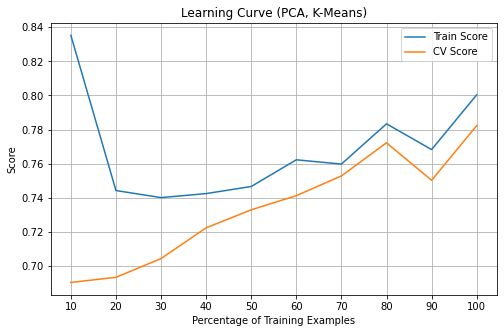

In [9]:
classifier_neural_network_learning = MLPClassifier(random_state=42, max_iter=2000, hidden_layer_sizes=classifier_neural_network_best.best_params_['hidden_layer_sizes'], alpha=classifier_neural_network_best.best_params_['alpha'])
_, train_scores, test_scores = learning_curve(classifier_neural_network_learning, X_KMeans_train, y_KMeans_train, train_sizes=np.linspace(0.1,1.0,10), cv=4)

plt.figure(figsize=(8,5))
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Learning Curve (PCA, K-Means)")
plt.xlabel("Percentage of Training Examples")
plt.ylabel("Score")
plt.xticks(np.linspace(0.1,1.0,10)*100)
plt.grid()
plt.savefig('minist_exp5_PCA_learning_curve_kmeans.png')
plt.show()

## EM (GMM)

In [10]:
gmm = mixture.GaussianMixture(n_components=7, covariance_type='full')
gmm.fit(X_PCA)
gmm.predict_proba(X_PCA)

array([[9.38489754e-005, 5.32093439e-005, 9.99802133e-001, ...,
        3.36248721e-005, 1.71841962e-005, 1.51783520e-014],
       [9.98959193e-001, 2.76006039e-004, 2.19710625e-037, ...,
        4.90920865e-004, 1.99201295e-004, 7.46706824e-005],
       [1.55366874e-008, 7.20444097e-003, 1.00829350e-030, ...,
        7.42621156e-001, 1.12973491e-003, 2.49044652e-001],
       ...,
       [3.15762898e-003, 2.74480449e-004, 1.04520800e-169, ...,
        2.57794861e-002, 2.98390600e-009, 9.70780015e-001],
       [9.67727186e-010, 1.29782034e-002, 4.24192676e-158, ...,
        7.55346938e-038, 9.68424196e-001, 4.80851673e-024],
       [1.58705615e-006, 4.23889304e-003, 1.40887650e-058, ...,
        9.95608138e-001, 6.36314197e-006, 1.45017480e-004]])

In [11]:
X_GMM = np.append(X_PCA, gmm.predict_proba(X_PCA), 1)
X_GMM_train, X_GMM_test, y_GMM_train, y_GMM_test = train_test_split(X_GMM, y, test_size=0.3, random_state=42)

In [12]:
classifier_neural_network = MLPClassifier(random_state=42, max_iter=2000)
param_grid = {'alpha': np.logspace(-3,3,7), 'hidden_layer_sizes': np.arange(2,25,2)}
classifier_neural_network_best = GridSearchCV(classifier_neural_network, param_grid=param_grid, cv=4)

start_time = time.time()
classifier_neural_network_best.fit(X_GMM_train, y_GMM_train)
end_time = time.time()
time_train = end_time-start_time
print("Best params for neural network:",classifier_neural_network_best.best_params_)
print("Time to train:",time_train)

start_time = time.time()
classifier_accuracy = accuracy_score(y_GMM_test, classifier_neural_network_best.predict(X_GMM_test))
end_time = time.time()
time_infer = end_time-start_time
print("Accuracy for best neural network:", classifier_accuracy)
print("Time to infer:",time_infer)

Best params for neural network: {'alpha': 100.0, 'hidden_layer_sizes': 22}
Time to train: 8182.075253009796
Accuracy for best neural network: 0.8006666666666666
Time to infer: 0.0029938220977783203


In [13]:
confusion_matrix(y_GMM_test, classifier_neural_network_best.predict(X_GMM_test))

array([[288,   0,   0,   4,   1,   4,   6,   0,   2,   1],
       [  0, 331,   0,   1,   0,   0,   2,   4,   0,   2],
       [  6,   1, 248,   8,   6,   2,   9,   1,  18,   0],
       [  0,   3,  11, 219,   4,  18,   3,   3,  35,   3],
       [  2,   3,   2,   0, 200,   2,   8,  11,   1,  58],
       [ 12,   3,   5,  27,   5, 186,   6,   9,   0,   5],
       [  6,   5,   8,   0,   4,   3, 218,   0,   1,   0],
       [  1,   6,   2,   1,  11,   0,   0, 283,   2,  28],
       [  5,   8,   7,  28,   4,   5,   4,   2, 250,  15],
       [  4,   6,   0,   6,  71,   6,   2,  23,   7, 179]])

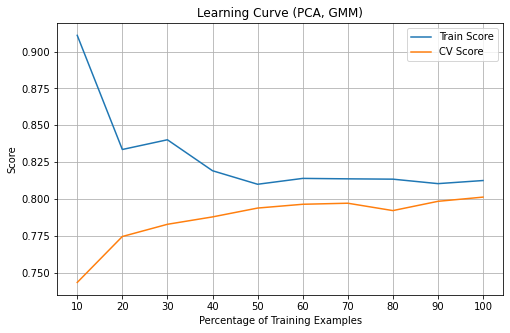

In [14]:
classifier_neural_network_learning = MLPClassifier(random_state=42, max_iter=2000, hidden_layer_sizes=classifier_neural_network_best.best_params_['hidden_layer_sizes'], alpha=classifier_neural_network_best.best_params_['alpha'])
_, train_scores, test_scores = learning_curve(classifier_neural_network_learning, X_GMM_train, y_GMM_train, train_sizes=np.linspace(0.1,1.0,10), cv=4)

plt.figure(figsize=(8,5))
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Learning Curve (PCA, GMM)")
plt.xlabel("Percentage of Training Examples")
plt.ylabel("Score")
plt.xticks(np.linspace(0.1,1.0,10)*100)
plt.grid()
plt.savefig('minist_exp5_PCA_learning_curve_gmm.png')
plt.show()